## TABLE OF CONTENTS
- [PART 1 - ***CLEANING***](#part-1)

    - [IMPORTING DEPENDENCIES](#1-importing-dependencies)

    - [DOWNLOADING DATASET](#2-scraping-the-data-from-the-url-i-created-a-script-called-scrapepy-that-does-the-scraping)

    - [HELPER FUNCTIONS](#3-defining-some-helper-functions-to-help-in-computation)
    
    - [DATA CLEANING](#4-data-cleaning)

        - [ALQ](#4.1-analysing-and-cleaning-the-alcohol-intake-questionaire-alq-files)

        - [BMX](#4.2-analysing-and-cleaning-the-body-measurement-bmx-files)
        
        - [BPQ](#4.3-analysing-and-cleaning-the-blood-pressure-questionnaire-bpq-files)

        - [BPX](#4.4-analysing-and-cleaning-the-non-oscillometric-blood-pressure-bpx-files)

        - [DEMO](#4.5-analysing-and-cleaning-the-demographic-information-demo-files)

        - [DIQ](#4.6-analysing-and-cleaning-the-diabetes-questionnaire-diq-files)

        - [PAQ](#4.7-analysing-and-cleaning-the-physical-activity-questionnaire-paq-files)
        
        - [SMQ](#4.8-analysing-and-cleaning-the-smoking-questionnaire-smq-files)

- [PART 2 - ***VISUALIZATION***](#part-2)

    - [CLEANING MERGED DATA](#1-loading-merged-dataset)

        - [TENTATIVE METHOD 1 ANALYSIS](#11-tentative-analysis)
        
        - [TENTATIVE METHOD 2 ANALYSIS](#12-final-analysis)
    
    - [GENERATING PLOTS](#2-visualization)

- [PART 3 - ***MACHINE LEARNING***](#part-3)

    - [PREPROCESSING](#1-preprocessing)

    - [SECONDARY MODELS](#2-secondary-models-svm-lr-knn-nb-rfc-dtc)

        - [SPLITTING DATA](#21-splitting-data)

        - [TRAINING MODELS](#22-training-models)

    - [PRIMARY MODEL](#3-primary-model-mpc)

        - [SPLITTING DATA](#31-splitting-data)

        - [TRAINING MODELS](#32-training-model)

    - [SUMMARY MODEL](#summary)

# PART 1

## 1. IMPORTING DEPENDENCIES

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sec_models import ModelSelector

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from prim_model import BP_Dataset, MLPClassifier
from training import Trainer

dataDir = "data"
downloaded = True
if not os.path.exists(dataDir):
    from scrape import DataDownloader
    downloaded = False

## 2. DOWNLOADING DATASETS FROM NHANES

In [2]:

if not downloaded:
    base_url = "https://wwwn.cdc.gov"
    url = base_url + "/nchs/nhanes/search/datapage.aspx"
    data_dir = 'data'
    prefixes = ['BPX', 'BMX', 'DEMO', 'BPQ', 'DIQ', 'SMQ', 'ALQ', 'PAQ']

    downloader = DataDownloader(base_url, url, data_dir, prefixes)
    downloader.download_files()


## 3. DEFINING SOME HELPER FUNCTIONS TO HELP IN COMPUTATION

In [3]:
fileIDs = ["B", "C", "D", "E", "F", "G", "H","I", "J"]

# Helper function to display a file's basic information
def getFileInfo(prefix, fileName):
    df = pd.read_sas(f"data/{prefix}/{fileName}")

    print(f"INFORMATION ABOUT THE {fileName}")
    print("--------------------------------")
    print("Number of columns: ", len(df.columns))
    print("Column names: ", list(df.columns))

# Helper function to clean ALQ files
# . is missing, 8 is could not obtain, 7 is Refused, 9 is dont know
def preprocessALQ(df):
    df = df.copy()
    if 'ALQ121' in df.columns and 'ALQ120Q' not in df.columns:
        df.rename(columns={'ALQ121': 'ALQ120Q'}, inplace=True)
    df = df[['SEQN','ALQ120Q','ALQ130']]
    df.replace({999: np.nan}, inplace=True)  # 999 dont know
    return df

# Helper function to clean BMX files
def preprocessBMX(df):
    df = df.copy()
    df = df[['SEQN', 'BMXWT','BMXBMI','BMXWAIST', "BMXHEAD", "BMXARMC", "BMXLEG"]]
    df.replace({'.': np.nan}, inplace=True) #. is missing
    return df

# Helper function to clean BPQ files
def preprocessBPQ(df):
    df = df.copy()
    df = df[['SEQN', 'BPQ020','BPQ040A','BPQ050A', "BPQ090D", "BPQ100D"]]
    df.replace({'.': np.nan, 7: np.nan, 9: np.nan}, inplace=True) # . is missing, 7 is Refused, 9 is dont know
    return df

# Helper function to clean BPX files
def preprocessBPX(df):
    df = df.copy()
    df = df[['SEQN', 'BPXCHR','BPXPLS','BPXSY1', "BPXSY2", "BPXSY3", "BPXSY4",'BPXDI1', "BPXDI2", "BPXDI3", "BPXDI4"]]
    
    df.replace({'.': np.nan, 8: np.nan}, inplace=True) # . is missing, 8 is could not obtain
    return df

# Helper function to clean DEMO files
def preprocessDEMO(df):
    df = df.copy()
    df = df[['SEQN', 'RIAGENDR','RIDAGEYR','RIDRETH1']]
    df.replace({'.': np.nan}, inplace=True) # . is missing
    return df

# Helper function to clean DIQ files
def preprocessDIQ(df):
    df = df.copy()
    df = df[['SEQN', 'DIQ010','DIQ050']]
    df.replace({'.': np.nan, 7: np.nan, 9: np.nan, 3:2}, inplace=True) # 3 is borderline
    return df

# Helper function to clean PAQ files
def preprocessPAQ(df):
    df = df.copy()
    if 'PAD200' in df.columns and 'PAQ605' not in df.columns:
        df.rename(columns={'PAD200': 'PAQ605'}, inplace=True)

    df = df[['SEQN', 'PAQ605']]
    df.replace({'.': np.nan, 3: np.nan, 7: np.nan, 9: np.nan}, inplace=True) # . is missing, 7 is Refused, 9 is dont know
    return df

# Helper function to clean SMQ files
def preprocessSMQ(df):
    df = df.copy()
    df = df[['SEQN', 'SMQ020', 'SMQ040']]
    df.replace({'.': np.nan, 7: np.nan, 9: np.nan}, inplace=True) # . is missing, 7 is Refused, 9 is dont know
    return df
        
# Helper function to concatenate (append) files
def concatenate_files(prefix):
    dir_name = os.path.join('data', prefix)

    df_list = []
    for file_name in os.listdir(dir_name):
        if file_name.endswith('.XPT'):
            file_path = os.path.join(dir_name, file_name)

            df = pd.read_sas(file_path)

            if prefix == "ALQ":
                df = preprocessALQ(df)
            elif prefix == "BMX":
                df = preprocessBMX(df)
            elif prefix == "BPQ":
                df = preprocessBPQ(df)
            elif prefix == "BPX":
                df = preprocessBPX(df)
            elif prefix == "DEMO":
                df = preprocessDEMO(df)
            elif prefix == "DIQ":
                df = preprocessDIQ(df)
            elif prefix == "PAQ":
                df = preprocessPAQ(df)
            elif prefix == "SMQ":
                df = preprocessSMQ(df)
            else:
                print(f"Sorry {prefix} not available")
                return

            df_list.append(df)

    df_all = pd.concat(df_list, ignore_index=True)

    new_file_path = os.path.join(dir_name, f'all_{prefix}.csv')
    df_all.to_csv(new_file_path, index=False)

    print(f"All files in {prefix} concatenated and saved to {new_file_path}")


# 4. DATA CLEANING

### 4.1 ANALYSING AND CLEANING THE ALCOHOL INTAKE QUESTIONAIRE (ALQ) FILES

In [4]:
folderName = "ALQ"
dataFiles = os.listdir("data/" + folderName)

# check whether all files have been appended already
allFiles = "all_" + folderName + ".csv"
if allFiles in dataFiles:
    dataFiles.remove(allFiles) # then remove the appended file from the dataFiles list
    
for ID in dataFiles:
    getFileInfo(folderName, ID)
    print("\n")

INFORMATION ABOUT THE ALQ_B.XPT
--------------------------------
Number of columns:  9
Column names:  ['SEQN', 'ALD100', 'ALQ110', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'ALQ140Q', 'ALQ140U', 'ALQ150']


INFORMATION ABOUT THE ALQ_C.XPT
--------------------------------
Number of columns:  9
Column names:  ['SEQN', 'ALQ101', 'ALQ110', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'ALQ140Q', 'ALQ140U', 'ALQ150']


INFORMATION ABOUT THE ALQ_D.XPT
--------------------------------
Number of columns:  9
Column names:  ['SEQN', 'ALQ101', 'ALQ110', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'ALQ140Q', 'ALQ140U', 'ALQ150']


INFORMATION ABOUT THE ALQ_E.XPT
--------------------------------
Number of columns:  9
Column names:  ['SEQN', 'ALQ101', 'ALQ110', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'ALQ140Q', 'ALQ140U', 'ALQ150']


INFORMATION ABOUT THE ALQ_F.XPT
--------------------------------
Number of columns:  9
Column names:  ['SEQN', 'ALQ101', 'ALQ110', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'ALQ140Q', 'ALQ140U', 'ALQ150']


INFORMATION ABO

**After a thorough analysis of the ALQ files and a comparison with the NHANES documentation, the following columns have been identified as important:**

- **`ALQ120Q`**: Represents the number of days alcohol was consumed per year.
- **`ALQ130`**: Provides the average number of alcoholic drinks consumed per day in the past 12 months.


 **From these two columns the number of alcohol consumed in the last 12 months can be calculated using the formula:**
        ```
        ALQ120Q * ALQ130
        ```


**Note on Column Consistency:**

***To maintain consistency across all files, some column names will be changed:***

**1. For the file `ALQ_J`, the column `ALQ121` will be renamed to `ALQ120Q`**

***This ensures that the same type of data is represented by the same column name across all files.***


In [5]:
# append the ALQ files and save as a csv file
concatenate_files("ALQ")

All files in ALQ concatenated and saved to data\ALQ\all_ALQ.csv


In [6]:
# Load ALQ file containing all subjects across 9 files
folderName = "ALQ"
fileName = "all_" + folderName + ".csv"
df = pd.read_csv(f"data/{folderName}/{fileName}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49115 entries, 0 to 49114
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SEQN     49115 non-null  float64
 1   ALQ120Q  37806 non-null  float64
 2   ALQ130   29265 non-null  float64
dtypes: float64(3)
memory usage: 1.1 MB


In [7]:
df.describe()

,SEQN,ALQ120Q,ALQ130
count,49115.000000,3.780600e+04,29265.000000
mean,58653.839519,4.194149e+00,2.911533
std,26563.785102,1.835010e+01,8.436067
min,9966.000000,5.397605e-79,1.000000
25%,36672.000000,1.000000e+00,1.000000
50%,59108.000000,2.000000e+00,2.000000
75%,81984.000000,4.000000e+00,3.000000
max,102956.000000,7.770000e+02,777.000000


### 4.2 ANALYSING AND CLEANING THE BODY MEASUREMENT (BMX) FILES

In [8]:
folderName = "BMX"
dataFiles = os.listdir("data/" + folderName)

# check whether all files have been appended already
allFiles = "all_" + folderName + ".csv"
if allFiles in dataFiles:
    dataFiles.remove(allFiles) # then remove the appended file from the dataFiles list.
                               # this will prevent the appended file from being also redundantly displayed below.
    
for ID in dataFiles:
    getFileInfo(folderName, ID)
    print("\n")

INFORMATION ABOUT THE BMX_B.XPT
--------------------------------
Number of columns:  26
Column names:  ['SEQN', 'BMXWT', 'BMIWT', 'BMXRECUM', 'BMIRECUM', 'BMXHEAD', 'BMIHEAD', 'BMXHT', 'BMIHT', 'BMXBMI', 'BMXLEG', 'BMILEG', 'BMXCALF', 'BMICALF', 'BMXARML', 'BMIARML', 'BMXARMC', 'BMIARMC', 'BMXWAIST', 'BMIWAIST', 'BMXTHICR', 'BMITHICR', 'BMXTRI', 'BMITRI', 'BMXSUB', 'BMISUB']


INFORMATION ABOUT THE BMX_C.XPT
--------------------------------
Number of columns:  33
Column names:  ['SEQN', 'BMDSTATS', 'BMDRECUF', 'BMDSUBF', 'BMDTHICF', 'BMDLEGF', 'BMDARMLF', 'BMDCALFF', 'BMXWT', 'BMIWT', 'BMXRECUM', 'BMIRECUM', 'BMXHEAD', 'BMIHEAD', 'BMXHT', 'BMIHT', 'BMXBMI', 'BMXLEG', 'BMILEG', 'BMXCALF', 'BMICALF', 'BMXARML', 'BMIARML', 'BMXARMC', 'BMIARMC', 'BMXWAIST', 'BMIWAIST', 'BMXTHICR', 'BMITHICR', 'BMXTRI', 'BMITRI', 'BMXSUB', 'BMISUB']


INFORMATION ABOUT THE BMX_D.XPT
--------------------------------
Number of columns:  27
Column names:  ['SEQN', 'BMDSTATS', 'BMXWT', 'BMIWT', 'BMXRECUM', 'BMI

**After a thorough analysis of the BMX files and reading few literatures online, the following columns have been identified as important with respect to Blood Pressue:**

- **`BMXWT`**: Weight (kg)
- **`BMXBMI`**: Body Mass Index (kg/m**2)
- **`BMXWAIST`**: Waist Circumference (cm)
- **`BMXHEAD`**: Head Circumference (cm)
- **`BMXARMC`**: Arm Circumference 
- **`BMXLEG`**: Upper Leg Length (cm)
        



In [9]:
concatenate_files("BMX")

All files in BMX concatenated and saved to data\BMX\all_BMX.csv


In [10]:
# Load BMX file containing all subjects across 9 files
folderName = "BMX"
fileName = "all_" + folderName + ".csv"
df = pd.read_csv(f"data/{folderName}/{fileName}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87484 entries, 0 to 87483
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      87484 non-null  float64
 1   BMXWT     85985 non-null  float64
 2   BMXBMI    79337 non-null  float64
 3   BMXWAIST  76415 non-null  float64
 4   BMXHEAD   2229 non-null   float64
 5   BMXARMC   82805 non-null  float64
 6   BMXLEG    65608 non-null  float64
dtypes: float64(7)
memory usage: 4.7 MB


BMXHEAD will likely be dropped due to large number of null entries

In [11]:
df.describe()

,SEQN,BMXWT,BMXBMI,BMXWAIST,BMXHEAD,BMXARMC,BMXLEG
count,87484.000000,85985.000000,79337.000000,76415.000000,2229.000000,82805.000000,65608.000000
mean,56154.879704,61.977737,25.558281,86.878545,41.403724,28.334643,38.687738
std,26902.028855,31.891227,7.679373,22.103946,2.607831,7.883856,4.249041
min,9966.000000,2.400000,7.990000,32.000000,32.300000,9.600000,20.400000
25%,32944.750000,37.700000,19.710000,71.200000,39.500000,22.500000,36.000000
50%,55638.500000,65.100000,24.800000,87.700000,41.700000,29.200000,38.800000
75%,79981.250000,82.900000,29.940000,102.200000,43.300000,33.900000,41.600000
max,102956.000000,371.000000,130.210000,179.000000,50.200000,62.400000,55.500000


In [12]:
df.corr()

,SEQN,BMXWT,BMXBMI,BMXWAIST,BMXHEAD,BMXARMC,BMXLEG
SEQN,1.000000,0.038847,0.060603,0.058749,-0.049688,0.043369,-0.117045
BMXWT,0.038847,1.000000,0.910833,0.947809,0.870059,0.965461,0.431720
BMXBMI,0.060603,0.910833,1.000000,0.932032,NaN,0.916697,0.113814
BMXWAIST,0.058749,0.947809,0.932032,1.000000,NaN,0.925401,0.200875
BMXHEAD,-0.049688,0.870059,NaN,NaN,1.000000,0.498812,NaN
BMXARMC,0.043369,0.965461,0.916697,0.925401,0.498812,1.000000,0.324470
BMXLEG,-0.117045,0.431720,0.113814,0.200875,NaN,0.324470,1.000000


### 4.3 ANALYSING AND CLEANING THE BLOOD PRESSURE QUESTIONNAIRE (BPQ) FILES

In [13]:
folderName = "BPQ"
dataFiles = os.listdir("data/" + folderName)

# check whether all files have been appended already
allFiles = "all_" + folderName + ".csv"
if allFiles in dataFiles:
    dataFiles.remove(allFiles) # then remove the appended file from the dataFiles list.
                               # this will prevent the appended file from being also redundantly displayed below.
    
for ID in dataFiles:
    getFileInfo(folderName, ID)
    print("\n")

INFORMATION ABOUT THE BPQ_B.XPT
--------------------------------
Number of columns:  36
Column names:  ['SEQN', 'BPQ010', 'BPQ020', 'BPQ030', 'BPQ040A', 'BPQ040B', 'BPQ040C', 'BPQ040D', 'BPQ040E', 'BPQ040F', 'BPQ043A', 'BPQ043B', 'BPQ043C', 'BPQ043D', 'BPQ050A', 'BPQ050B', 'BPQ050C', 'BPQ050D', 'BPQ050E', 'BPQ060', 'BPQ070', 'BPQ080', 'BPQ090A', 'BPQ090B', 'BPQ090C', 'BPQ090D', 'BPQ100A', 'BPQ100B', 'BPQ100C', 'BPQ100D', 'BPD110A', 'BPD110B', 'BPD110C', 'BPD120', 'BPD130', 'BPD140']


INFORMATION ABOUT THE BPQ_C.XPT
--------------------------------
Number of columns:  36
Column names:  ['SEQN', 'BPQ010', 'BPQ020', 'BPQ030', 'BPQ040A', 'BPQ040B', 'BPQ040C', 'BPQ040D', 'BPQ040E', 'BPQ040F', 'BPQ043A', 'BPQ043B', 'BPQ043C', 'BPQ043D', 'BPQ050A', 'BPQ050B', 'BPQ050C', 'BPQ050D', 'BPQ050E', 'BPQ060', 'BPQ070', 'BPQ080', 'BPQ090A', 'BPQ090B', 'BPQ090C', 'BPQ090D', 'BPQ100A', 'BPQ100B', 'BPQ100C', 'BPQ100D', 'BPD110A', 'BPD110B', 'BPD110C', 'BPD120', 'BPD130', 'BPD140']


INFORMATION ABOUT TH

**After a thorough analysis of the BPQ files and reading the documentation and applying some general knowledge about blood pressure, the following columns have been identified as important with respect to Blood Pressue:**

- **`BPQ020`**: Ever told you had high blood pressure?
- **`BPQ040A`**: Taking prescription for hypertension
- **`BPQ050A`**: Now taking prescribed medicine?
- **`BPQ090D`**: Told to take prescriptn for cholesterol?
- **`BPQ100D`**: Now taking prescribed medicine
        



In [14]:
concatenate_files("BPQ")

All files in BPQ concatenated and saved to data\BPQ\all_BPQ.csv


In [15]:
# Load BPQ file containing all subjects across 9 files
folderName = "BPQ"
fileName = "all_" + folderName + ".csv"
df = pd.read_csv(f"data/{folderName}/{fileName}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57548 entries, 0 to 57547
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SEQN     57548 non-null  float64
 1   BPQ020   57279 non-null  float64
 2   BPQ040A  17881 non-null  float64
 3   BPQ050A  15296 non-null  float64
 4   BPQ090D  25840 non-null  float64
 5   BPQ100D  11068 non-null  float64
dtypes: float64(6)
memory usage: 2.6 MB


In [16]:
df.describe()

,SEQN,BPQ020,BPQ040A,BPQ050A,BPQ090D,BPQ100D
count,57548.000000,57279.000000,17881.000000,15296.000000,25840.000000,11068.000000
mean,56894.064016,1.687460,1.144287,1.125850,1.571091,1.214040
std,26918.544495,0.463533,0.351391,0.331691,0.494930,0.410174
min,9966.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,33788.750000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,56597.500000,2.000000,1.000000,1.000000,2.000000,1.000000
75%,80740.250000,2.000000,1.000000,1.000000,2.000000,1.000000
max,102956.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [17]:
df.corr()

,SEQN,BPQ020,BPQ040A,BPQ050A,BPQ090D,BPQ100D
SEQN,1.000000,-0.055614,-0.079278,0.036158,0.208374,0.078209
BPQ020,-0.055614,1.000000,NaN,NaN,0.367295,0.148513
BPQ040A,-0.079278,NaN,1.000000,NaN,0.257093,0.116764
BPQ050A,0.036158,NaN,NaN,1.000000,0.151910,0.415579
BPQ090D,0.208374,0.367295,0.257093,0.151910,1.000000,NaN
BPQ100D,0.078209,0.148513,0.116764,0.415579,NaN,1.000000


### 4.4 ANALYSING AND CLEANING THE NON OSCILLOMETRIC BLOOD PRESSURE (BPX) FILES

In [18]:
folderName = "BPX"
dataFiles = os.listdir("data/" + folderName)

# check whether all files have been appended already
allFiles = "all_" + folderName + ".csv"
if allFiles in dataFiles:
    dataFiles.remove(allFiles) # then remove the appended file from the dataFiles list.
                               # this will prevent the appended file from being also redundantly displayed below.
    
for ID in dataFiles:
    getFileInfo(folderName, ID)
    print("\n")

INFORMATION ABOUT THE BPX_B.XPT
--------------------------------
Number of columns:  30
Column names:  ['SEQN', 'PEASCST1', 'PEASCTM1', 'PEASCCT1', 'BPXCHR', 'BPQ150A', 'BPQ150B', 'BPQ150C', 'BPQ150D', 'BPAARM', 'BPACSZ', 'BPXPLS', 'BPXDB', 'BPXPULS', 'BPXPTY', 'BPXML1', 'BPXSY1', 'BPXDI1', 'BPAEN1', 'BPXSY2', 'BPXDI2', 'BPAEN2', 'BPXSY3', 'BPXDI3', 'BPAEN3', 'BPXSY4', 'BPXDI4', 'BPAEN4', 'BPXSAR', 'BPXDAR']


INFORMATION ABOUT THE BPX_C.XPT
--------------------------------
Number of columns:  30
Column names:  ['SEQN', 'PEASCST1', 'PEASCTM1', 'PEASCCT1', 'BPXCHR', 'BPQ150A', 'BPQ150B', 'BPQ150C', 'BPQ150D', 'BPAARM', 'BPACSZ', 'BPXPLS', 'BPXDB', 'BPXPULS', 'BPXPTY', 'BPXML1', 'BPXSY1', 'BPXDI1', 'BPAEN1', 'BPXSY2', 'BPXDI2', 'BPAEN2', 'BPXSY3', 'BPXDI3', 'BPAEN3', 'BPXSY4', 'BPXDI4', 'BPAEN4', 'BPXSAR', 'BPXDAR']


INFORMATION ABOUT THE BPX_D.XPT
--------------------------------
Number of columns:  28
Column names:  ['SEQN', 'PEASCST1', 'PEASCTM1', 'PEASCCT1', 'BPXCHR', 'BPQ150A', 'BP

**After a thorough analysis of the BPX files and reading the documentation and applying some general knowledge about blood pressure, the following columns have been identified as important with respect to Blood Pressue:**

- **`BPXSY`**: Systolic: Blood pres mm Hg (1st, 2nd, 3rd, 4th)
- **`BPXDI`**: Diastolic: Blood pres mm Hg (1st, 2nd, 3rd, 4th)
- **`BPXCHR`**: 60 sec HR (30 sec HR * 2)
- **`BPXPLS`**: 60 sec. pulse (30 sec. pulse * 2):
        



In [19]:
# append the BPX files and save as a csv file
concatenate_files("BPX")

All files in BPX concatenated and saved to data\BPX\all_BPX.csv


In [20]:
# Load BPQ file containing all subjects across 9 files
folderName = "BPX"
fileName = "all_" + folderName + ".csv"
df = pd.read_csv(f"data/{folderName}/{fileName}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87484 entries, 0 to 87483
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    87484 non-null  float64
 1   BPXCHR  17725 non-null  float64
 2   BPXPLS  66623 non-null  float64
 3   BPXSY1  62119 non-null  float64
 4   BPXSY2  61566 non-null  float64
 5   BPXSY3  61072 non-null  float64
 6   BPXSY4  6823 non-null   float64
 7   BPXDI1  62117 non-null  float64
 8   BPXDI2  61565 non-null  float64
 9   BPXDI3  61069 non-null  float64
 10  BPXDI4  6823 non-null   float64
dtypes: float64(11)
memory usage: 7.3 MB


***BPXCHR can be dropped due to large null values***

In [21]:
df.describe()

,SEQN,BPXCHR,BPXPLS,BPXSY1,BPXSY2,BPXSY3,BPXSY4,BPXDI1,BPXDI2,BPXDI3,BPXDI4
count,87484.000000,1.772500e+04,6.662300e+04,62119.000000,61566.000000,61072.000000,6823.000000,6.211700e+04,6.156500e+04,6.106900e+04,6.823000e+03
mean,56154.879704,1.068793e+02,7.446687e+01,119.813809,119.220186,118.616420,121.335190,6.631605e+01,6.620765e+01,6.604883e+01,6.728419e+01
std,26902.028855,2.116279e+01,1.266894e+01,19.387117,19.075014,18.692661,21.415329,1.491986e+01,1.504535e+01,1.526140e+01,1.694660e+01
min,9966.000000,5.397605e-79,5.397605e-79,66.000000,66.000000,62.000000,70.000000,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
25%,32944.750000,9.200000e+01,6.600000e+01,106.000000,106.000000,106.000000,106.000000,5.800000e+01,5.800000e+01,5.800000e+01,5.800000e+01
50%,55638.500000,1.040000e+02,7.400000e+01,116.000000,116.000000,116.000000,118.000000,6.800000e+01,6.800000e+01,6.800000e+01,6.800000e+01
75%,79981.250000,1.200000e+02,8.200000e+01,130.000000,128.000000,128.000000,132.000000,7.600000e+01,7.600000e+01,7.600000e+01,7.800000e+01
max,102956.000000,3.040000e+02,2.240000e+02,270.000000,256.000000,238.000000,248.000000,1.360000e+02,1.440000e+02,1.400000e+02,1.320000e+02


In [22]:
df.corr()

,SEQN,BPXCHR,BPXPLS,BPXSY1,BPXSY2,BPXSY3,BPXSY4,BPXDI1,BPXDI2,BPXDI3,BPXDI4
SEQN,1.000000,-0.033174,-0.016890,0.005803,0.030438,0.041175,0.152837,0.022215,0.014623,0.014230,0.165923
BPXCHR,-0.033174,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BPXPLS,-0.016890,NaN,1.000000,-0.158703,-0.148674,-0.139828,-0.157343,-0.049266,-0.047809,-0.040638,-0.031922
BPXSY1,0.005803,NaN,-0.158703,1.000000,0.958506,0.948468,0.934771,0.407454,0.398246,0.373207,0.271870
BPXSY2,0.030438,NaN,-0.148674,0.958506,1.000000,0.961977,0.958025,0.434839,0.408767,0.391456,0.308963
BPXSY3,0.041175,NaN,-0.139828,0.948468,0.961977,1.000000,0.966793,0.431723,0.415013,0.392390,0.284685
BPXSY4,0.152837,NaN,-0.157343,0.934771,0.958025,0.966793,1.000000,0.342992,0.371301,0.311418,0.309601
BPXDI1,0.022215,NaN,-0.049266,0.407454,0.434839,0.431723,0.342992,1.000000,0.878216,0.858166,0.840393
BPXDI2,0.014623,NaN,-0.047809,0.398246,0.408767,0.415013,0.371301,0.878216,1.000000,0.897087,0.870644
BPXDI3,0.014230,NaN,-0.040638,0.373207,0.391456,0.392390,0.311418,0.858166,0.897087,1.000000,0.903615


### 4.5 ANALYSING AND CLEANING THE DEMOGRAPHIC INFORMATION (DEMO) FILES

In [23]:
folderName = "DEMO"
dataFiles = os.listdir("data/" + folderName)

# check whether all files have been appended already
allFiles = "all_" + folderName + ".csv"
if allFiles in dataFiles:
    dataFiles.remove(allFiles) # then remove the appended file from the dataFiles list.
                               # this will prevent the appended file from being also redundantly displayed below.
    
for ID in dataFiles:
    getFileInfo(folderName, ID)
    print("\n")

INFORMATION ABOUT THE DEMO_B.XPT
--------------------------------
Number of columns:  37
Column names:  ['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIDEXMON', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDAGEEX', 'RIDRETH1', 'RIDRETH2', 'DMQMILIT', 'DMDBORN', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDEDUC', 'DMDSCHOL', 'DMDMARTL', 'DMDHHSIZ', 'INDHHINC', 'INDFMINC', 'INDFMPIR', 'RIDEXPRG', 'RIDPREG', 'DMDHRGND', 'DMDHRAGE', 'DMDHRBRN', 'DMDHREDU', 'DMDHRMAR', 'DMDHSEDU', 'WTINT2YR', 'WTINT4YR', 'WTMEC2YR', 'WTMEC4YR', 'SDMVPSU', 'SDMVSTRA']


INFORMATION ABOUT THE DEMO_C.XPT
--------------------------------
Number of columns:  44
Column names:  ['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIDEXMON', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDAGEEX', 'RIDRETH1', 'RIDRETH2', 'DMQMILIT', 'DMDBORN', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDEDUC', 'DMDSCHOL', 'DMDMARTL', 'DMDHHSIZ', 'INDHHINC', 'INDFMINC', 'INDFMPIR', 'RIDEXPRG', 'DMDHRGND', 'DMDHRAGE', 'DMDHRBRN', 'DMDHREDU', 'DMDHRMAR', 'DMDHSEDU'

**After a thorough analysis of the DEMO files and reading the documentation and applying some general knowledge about blood pressure, the following columns have been identified as important with respect to Blood Pressue:**

- **`RIAGENDR`**: Gender of the sample person
- **`RIDAGEYR`**: Best age in years of the sample person at time of HH screening. Individuals 85 and over are topcoded at 85 years of age.
- **`RIDRETH1`**: Race/Ethnicity - Recode
      



In [24]:
# append the DEMO files and save as a csv file
concatenate_files("DEMO")

All files in DEMO concatenated and saved to data\DEMO\all_DEMO.csv


In [25]:
# Load DEMO file containing all subjects across 9 files
folderName = "DEMO"
fileName = "all_" + folderName + ".csv"
df = pd.read_csv(f"data/{folderName}/{fileName}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91351 entries, 0 to 91350
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      91351 non-null  float64
 1   RIAGENDR  91351 non-null  float64
 2   RIDAGEYR  91351 non-null  float64
 3   RIDRETH1  91351 non-null  float64
dtypes: float64(4)
memory usage: 2.8 MB


***No missing values***

In [26]:
df.describe()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1
count,91351.000000,91351.000000,9.135100e+04,91351.000000
mean,56168.810314,1.507285,3.128095e+01,2.932316
std,26994.637967,0.499950,2.495074e+01,1.243978
min,9966.000000,1.000000,5.397605e-79,1.000000
25%,32803.500000,1.000000,1.000000e+01,2.000000
50%,55641.000000,2.000000,2.500000e+01,3.000000
75%,80118.500000,2.000000,5.200000e+01,4.000000
max,102956.000000,2.000000,8.500000e+01,5.000000


### 4.6 ANALYSING AND CLEANING THE DIABETES QUESTIONNAIRE (DIQ) FILES

In [27]:
folderName = "DIQ"
dataFiles = os.listdir("data/" + folderName)

# check whether all files have been appended already
allFiles = "all_" + folderName + ".csv"
if allFiles in dataFiles:
    dataFiles.remove(allFiles) # then remove the appended file from the dataFiles list.
                               # this will prevent the appended file from being also redundantly displayed below.
    
for ID in dataFiles:
    getFileInfo(folderName, ID)
    print("\n")

INFORMATION ABOUT THE DIQ_B.XPT
--------------------------------
Number of columns:  17
Column names:  ['SEQN', 'DIQ010', 'DID040G', 'DID040Q', 'DIQ050', 'DID060G', 'DID060Q', 'DIQ060U', 'DIQ070', 'DIQ080', 'DIQ090', 'DIQ100', 'DIQ110', 'DIQ120', 'DIQ130', 'DIQ140', 'DIQ150']


INFORMATION ABOUT THE DIQ_C.XPT
--------------------------------
Number of columns:  17
Column names:  ['SEQN', 'DIQ010', 'DID040G', 'DID040Q', 'DIQ050', 'DID060G', 'DID060Q', 'DIQ060U', 'DIQ070', 'DIQ080', 'DIQ090', 'DIQ100', 'DIQ110', 'DIQ120', 'DIQ130', 'DIQ140', 'DIQ150']


INFORMATION ABOUT THE DIQ_D.XPT
--------------------------------
Number of columns:  36
Column names:  ['SEQN', 'DIQ010', 'DID040', 'DIQ220', 'DIQ160', 'DIQ170', 'DIQ180', 'DIQ190A', 'DIQ190B', 'DIQ190C', 'DIQ200A', 'DIQ200B', 'DIQ200C', 'DIQ050', 'DID060', 'DIQ060U', 'DID070', 'DIQ230', 'DIQ240', 'DID250', 'DID260', 'DIQ260U', 'DID270', 'DIQ280', 'DIQ290', 'DIQ300S', 'DIQ300D', 'DID310S', 'DID310D', 'DID320', 'DID330', 'DID340', 'DID350'

**After a thorough analysis of the BPX files and reading the documentation and applying some general knowledge about blood pressure, the following columns have been identified as important with respect to Blood Pressue:**

- **`DIQ010`**: Doctor told you have diabetes
- **`DIQ050`**: Take diabetic pills to lower blood sugar

        



In [28]:
# append the DIQ files and save as a csv file
concatenate_files("DIQ")

All files in DIQ concatenated and saved to data\DIQ\all_DIQ.csv


In [29]:
# Load DIQ file containing all subjects across 9 files
folderName = "DIQ"
fileName = "all_" + folderName + ".csv"
df = pd.read_csv(f"data/{folderName}/{fileName}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87318 entries, 0 to 87317
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    87318 non-null  float64
 1   DIQ010  87262 non-null  float64
 2   DIQ050  87303 non-null  float64
dtypes: float64(3)
memory usage: 2.0 MB


In [30]:
df.corr()

,SEQN,DIQ010,DIQ050
SEQN,1.000000,-0.054010,-0.031612
DIQ010,-0.054010,1.000000,0.515834
DIQ050,-0.031612,0.515834,1.000000


### 4.7 ANALYSING AND CLEANING THE PHYSICAL ACTIVITY QUESTIONNAIRE (PAQ) FILES

In [31]:
folderName = "PAQ"
dataFiles = os.listdir("data/" + folderName)

# check whether all files have been appended already
allFiles = "all_" + folderName + ".csv"
if allFiles in dataFiles:
    dataFiles.remove(allFiles) # then remove the appended file from the dataFiles list.
                               # this will prevent the appended file from being also redundantly displayed below.
    
for ID in dataFiles:
    getFileInfo(folderName, ID)
    print("\n")

INFORMATION ABOUT THE PAQ_B.XPT
--------------------------------
Number of columns:  21
Column names:  ['SEQN', 'PAD020', 'PAQ050Q', 'PAQ050U', 'PAD080', 'PAQ100', 'PAD120', 'PAD160', 'PAQ180', 'PAD200', 'PAD320', 'PAD440', 'PAD460', 'PAD480', 'PAQ500', 'PAQ520', 'PAQ540', 'PAQ560', 'PAD590', 'PAD600', 'PAAQUEX']


INFORMATION ABOUT THE PAQ_C.XPT
--------------------------------
Number of columns:  20
Column names:  ['SEQN', 'PAD020', 'PAQ050Q', 'PAQ050U', 'PAD080', 'PAQ100', 'PAD120', 'PAD160', 'PAQ180', 'PAD200', 'PAD320', 'PAD440', 'PAD460', 'PAQ500', 'PAQ520', 'PAQ540', 'PAQ560', 'PAD590', 'PAD600', 'PAAQUEX']


INFORMATION ABOUT THE PAQ_D.XPT
--------------------------------
Number of columns:  20
Column names:  ['SEQN', 'PAD020', 'PAQ050Q', 'PAQ050U', 'PAD080', 'PAQ100', 'PAD120', 'PAD160', 'PAQ180', 'PAD200', 'PAD320', 'PAD440', 'PAD460', 'PAQ500', 'PAQ520', 'PAQ540', 'PAQ560', 'PAD590', 'PAD600', 'PAAQUEX']


INFORMATION ABOUT THE PAQ_E.XPT
--------------------------------
Numb

**Some files are missing the `PAQ605` column which asked whether subjects do vigorous exercises. The files missing the `PAQ605` column however have a column called PAD200 which also asks whether subjects perform rigourous training activities. For this questionnaire I am interested in whether subjects do exercise or not. So I will only take 1 column from this questionnaire and move on. Files that do not have the PAQ606 will have their `PAD200` renamed to `PAQ606` to ensure consistency when concatenating the datasets in the PAQ**

In [32]:
# append the PAQ files and save as a csv file
concatenate_files("PAQ")

All files in PAQ concatenated and saved to data\PAQ\all_PAQ.csv


In [33]:
# Load PAQ file containing all subjects across 9 files
folderName = "PAQ"
fileName = "all_" + folderName + ".csv"
df = pd.read_csv(f"data/{folderName}/{fileName}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81628 entries, 0 to 81627
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    81628 non-null  float64
 1   PAQ605  62632 non-null  float64
dtypes: float64(2)
memory usage: 1.2 MB


In [34]:
df.describe()

,SEQN,PAQ605
count,81628.000000,62632.000000
mean,54946.809894,1.737339
std,26271.334664,0.440083
min,9966.000000,1.000000
25%,32260.500000,1.000000
50%,54473.500000,2.000000
75%,78056.250000,2.000000
max,102956.000000,2.000000


### 4.8 ANALYSING AND CLEANING THE SMOKING QUESTIONNAIRE (SMQ) FILES

In [35]:
folderName = "SMQ"
dataFiles = os.listdir("data/" + folderName)

# check whether all files have been appended already
allFiles = "all_" + folderName + ".csv"
if allFiles in dataFiles:
    dataFiles.remove(allFiles) # then remove the appended file from the dataFiles list.
                               # this will prevent the appended file from being also redundantly displayed below.
    
for ID in dataFiles:
    getFileInfo(folderName, ID)
    print("\n")

INFORMATION ABOUT THE SMQ_B.XPT
--------------------------------
Number of columns:  42
Column names:  ['SEQN', 'SMQ020', 'SMD030', 'SMQ040', 'SMQ050Q', 'SMQ050U', 'SMD055', 'SMD057', 'SMD070', 'SMD075', 'SMQ077', 'SMD080', 'SMD090', 'SMD092', 'SMDUPCA', 'SMD100BR', 'SMD100FL', 'SMD100MN', 'SMD100LN', 'SMD100TR', 'SMD100NI', 'SMD100CO', 'SMQ120', 'SMD130', 'SMQ140', 'SMQ143', 'SMQ145', 'SMQ150', 'SMD160', 'SMQ170', 'SMQ173', 'SMQ175', 'SMQ180', 'SMD190', 'SMQ200', 'SMD203', 'SMQ205', 'SMQ210', 'SMD220', 'SMQ230', 'SMD233', 'SMD235']


INFORMATION ABOUT THE SMQ_C.XPT
--------------------------------
Number of columns:  42
Column names:  ['SEQN', 'SMQ020', 'SMD030', 'SMQ040', 'SMQ050Q', 'SMQ050U', 'SMD055', 'SMD057', 'SMD070', 'SMD075', 'SMQ077', 'SMD641', 'SMD650', 'SMD093', 'SMDUPCA', 'SMD100BR', 'SMD100FL', 'SMD100MN', 'SMD100LN', 'SMD100TR', 'SMD100NI', 'SMD100CO', 'SMQ120', 'SMD130', 'SMQ140', 'SMQ143', 'SMQ145', 'SMQ150', 'SMD160', 'SMQ170', 'SMQ173', 'SMQ175', 'SMQ180', 'SMD190', 

**After a thorough analysis of the SMQ files and reading the documentation and applying some general knowledge about blood pressure, the following columns have been identified as important with respect to Blood Pressue:**

- **`SMQ020`**: Smoked at least 100 cigarettes in life


In [36]:
# append the SMQ files and save as a csv file
concatenate_files("SMQ")

All files in SMQ concatenated and saved to data\SMQ\all_SMQ.csv


In [37]:
# Load SMQ file containing all subjects across 9 files
folderName = "SMQ"
fileName = "all_" + folderName + ".csv"
df = pd.read_csv(f"data/{folderName}/{fileName}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59994 entries, 0 to 59993
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    59994 non-null  float64
 1   SMQ020  51053 non-null  float64
 2   SMQ040  22833 non-null  float64
dtypes: float64(3)
memory usage: 1.4 MB


In [38]:
df.describe()

,SEQN,SMQ020,SMQ040
count,59994.000000,51053.000000,22833.000000
mean,58982.375388,1.552661,2.165199
std,26086.455498,0.497224,0.941455
min,9966.000000,1.000000,1.000000
25%,37682.250000,1.000000,1.000000
50%,58910.000000,2.000000,3.000000
75%,81918.750000,2.000000,3.000000
max,102956.000000,2.000000,3.000000


In [39]:
df.corr()

,SEQN,SMQ020,SMQ040
SEQN,1.000000,0.062776,0.010796
SMQ020,0.062776,1.000000,NaN
SMQ040,0.010796,NaN,1.000000


# PART 2

## 1. LOADING MERGED DATASET

### 1.1 TENTATIVE METHOD 1 ANALYSIS

In [40]:
prefixes = ['ALQ', 'BMX', 'BPQ', 'BPX', 'DEMO', 'DIQ', 'PAQ', 'SMQ']
dataDir = 'data'

for prefix in ['BPX', 'BMX', 'DEMO', 'BPQ', 'DIQ', 'SMQ', 'ALQ', 'PAQ']:
    fileName = f'all_{prefix}.csv'
    file_path = os.path.join(dataDir, prefix, fileName)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        print(f"{prefix} number of subjects:{len(df)}")


BPX number of subjects:87484
BMX number of subjects:87484
DEMO number of subjects:91351
BPQ number of subjects:57548
DIQ number of subjects:87318
SMQ number of subjects:59994
ALQ number of subjects:49115
PAQ number of subjects:81628


**Every prefixhas a column called `SEQN` where the ID of subject is stored. The same subjects are found across all prefixes and some prefixes have missing subjects, the maximum number of unique subjects in the merged dataset will be equal to the number of unique subjects in the prefix with the fewest subjects. Now knowing that the ALQ prefixes has the least number of subjects indicates that if I decide to merge the entire prefix into one dataset, the maximum number of unique subjects in the merged dataframe will be at most 49115**

In [41]:
file_path = os.path.join(dataDir, prefixes[0], f'all_{prefixes[0]}.csv')
df_merged_method1 = pd.read_csv(file_path)

for prefix in prefixes[1:]:
    file_path = os.path.join(dataDir, prefix, f'all_{prefix}.csv')
    df = pd.read_csv(file_path)
    
    df_merged_method1 = pd.merge(df_merged_method1, df, on='SEQN', how='left')

df_merged_method1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49115 entries, 0 to 49114
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      49115 non-null  float64
 1   ALQ120Q   37806 non-null  float64
 2   ALQ130    29265 non-null  float64
 3   BMXWT     48271 non-null  float64
 4   BMXBMI    48086 non-null  float64
 5   BMXWAIST  46185 non-null  float64
 6   BMXHEAD   0 non-null      float64
 7   BMXARMC   46735 non-null  float64
 8   BMXLEG    46023 non-null  float64
 9   BPQ020    48952 non-null  float64
 10  BPQ040A   16855 non-null  float64
 11  BPQ050A   14541 non-null  float64
 12  BPQ090D   24521 non-null  float64
 13  BPQ100D   10592 non-null  float64
 14  BPXCHR    0 non-null      float64
 15  BPXPLS    47054 non-null  float64
 16  BPXSY1    44149 non-null  float64
 17  BPXSY2    44184 non-null  float64
 18  BPXSY3    43928 non-null  float64
 19  BPXSY4    4412 non-null   float64
 20  BPXDI1    44148 non-null  fl

In [42]:
threshold = len(df_merged_method1) * 0.89  # column drop if it has at least 11% null values 
df_merged_method1 = df_merged_method1.dropna(thresh=threshold, axis=1)

medianSystole = df_merged_method1[['BPXSY1', 'BPXSY2', 'BPXSY3']].median(axis=1)
medianDiastole = df_merged_method1[['BPXDI1', 'BPXDI2', 'BPXDI3']].median(axis=1)
df_merged_method1['BP_Status'] = np.where((medianSystole >= 130) | (medianDiastole >= 80), 1, 2)

df_merged_method1.drop(columns=['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXDI1', 'BPXDI2', 'BPXDI3'], inplace=True)

df_merged_method1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49115 entries, 0 to 49114
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       49115 non-null  float64
 1   BMXWT      48271 non-null  float64
 2   BMXBMI     48086 non-null  float64
 3   BMXWAIST   46185 non-null  float64
 4   BMXARMC    46735 non-null  float64
 5   BMXLEG     46023 non-null  float64
 6   BPQ020     48952 non-null  float64
 7   BPXPLS     47054 non-null  float64
 8   RIAGENDR   49115 non-null  float64
 9   RIDAGEYR   49115 non-null  float64
 10  RIDRETH1   49115 non-null  float64
 11  DIQ010     49082 non-null  float64
 12  DIQ050     49109 non-null  float64
 13  PAQ605     48361 non-null  float64
 14  SMQ020     48780 non-null  float64
 15  BP_Status  49115 non-null  int32  
dtypes: float64(15), int32(1)
memory usage: 5.8 MB


In [43]:
df_merged_method1.head()

,SEQN,BMXWT,BMXBMI,BMXWAIST,BMXARMC,BMXLEG,BPQ020,BPXPLS,RIAGENDR,RIDAGEYR,RIDRETH1,DIQ010,DIQ050,PAQ605,SMQ020,BP_Status
0,9966.0,91.7,30.22,100.8,37.2,39.8,2.0,52.0,1.0,39.0,3.0,2.0,2.0,1.0,1.0,1
1,9967.0,84.0,29.98,88.7,37.1,41.5,2.0,56.0,1.0,23.0,4.0,2.0,2.0,1.0,2.0,2
2,9968.0,51.7,24.62,86.1,29.3,32.0,1.0,88.0,2.0,84.0,3.0,2.0,2.0,2.0,1.0,2
3,9969.0,58.0,22.26,74.0,27.2,38.7,2.0,90.0,2.0,51.0,3.0,2.0,2.0,1.0,2.0,2
4,9972.0,101.5,33.84,116.0,35.5,43.0,1.0,50.0,1.0,44.0,3.0,2.0,2.0,1.0,1.0,1


In [44]:
print("Correlation of BP_Status with Columns")
df_merged_method1.corr()["BP_Status"]

Correlation of BP_Status with Columns


SEQN         0.008660
BMXWT       -0.115701
BMXBMI      -0.119204
BMXWAIST    -0.181887
BMXARMC     -0.102829
BMXLEG       0.038897
BPQ020       0.301572
BPXPLS       0.005199
RIAGENDR     0.090465
RIDAGEYR    -0.349116
RIDRETH1    -0.046794
DIQ010       0.106715
DIQ050       0.050232
PAQ605      -0.037154
SMQ020       0.048566
BP_Status    1.000000
Name: BP_Status, dtype: float64

### 1.2 TENTATIVE METHOD 2 ANALYSIS

In [45]:
prefixes = ['PAQ', 'BMX', 'BPX', 'DEMO', 'DIQ']

file_path = os.path.join(dataDir, prefixes[0], f'all_{prefixes[0]}.csv')
df_merged_method2 = pd.read_csv(file_path)

for prefix in prefixes[1:]:
    file_path = os.path.join(dataDir, prefix, f'all_{prefix}.csv')
    df = pd.read_csv(file_path)
 
    df_merged_method2 = pd.merge(df_merged_method2, df, on='SEQN', how='left')

df_merged_method2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81628 entries, 0 to 81627
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      81628 non-null  float64
 1   PAQ605    62632 non-null  float64
 2   BMXWT     77145 non-null  float64
 3   BMXBMI    76766 non-null  float64
 4   BMXWAIST  73998 non-null  float64
 5   BMXHEAD   0 non-null      float64
 6   BMXARMC   74833 non-null  float64
 7   BMXLEG    64072 non-null  float64
 8   BPXCHR    10380 non-null  float64
 9   BPXPLS    65150 non-null  float64
 10  BPXSY1    60716 non-null  float64
 11  BPXSY2    60131 non-null  float64
 12  BPXSY3    59653 non-null  float64
 13  BPXSY4    6721 non-null   float64
 14  BPXDI1    60714 non-null  float64
 15  BPXDI2    60130 non-null  float64
 16  BPXDI3    59650 non-null  float64
 17  BPXDI4    6721 non-null   float64
 18  RIAGENDR  81628 non-null  float64
 19  RIDAGEYR  81628 non-null  float64
 20  RIDRETH1  81628 non-null  fl

In [46]:
threshold = len(df_merged_method2) * 0.70  # column drop if it has at least 30% null values 
df_merged_method2 = df_merged_method2.dropna(thresh=threshold, axis=1)

medianSystole = df_merged_method2[['BPXSY1', 'BPXSY2', 'BPXSY3']].median(axis=1)
medianDiastole = df_merged_method2[['BPXDI1', 'BPXDI2', 'BPXDI3']].median(axis=1)
df_merged_method2['BP_Status'] = np.where((medianSystole >= 130) | (medianDiastole >= 80), 1, 2)

df_merged_method2.drop(columns=['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXDI1', 'BPXDI2', 'BPXDI3'], inplace=True)

df_merged_method2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81628 entries, 0 to 81627
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       81628 non-null  float64
 1   PAQ605     62632 non-null  float64
 2   BMXWT      77145 non-null  float64
 3   BMXBMI     76766 non-null  float64
 4   BMXWAIST   73998 non-null  float64
 5   BMXARMC    74833 non-null  float64
 6   BMXLEG     64072 non-null  float64
 7   BPXPLS     65150 non-null  float64
 8   RIAGENDR   81628 non-null  float64
 9   RIDAGEYR   81628 non-null  float64
 10  RIDRETH1   81628 non-null  float64
 11  DIQ010     81575 non-null  float64
 12  DIQ050     81615 non-null  float64
 13  BP_Status  81628 non-null  int32  
dtypes: float64(13), int32(1)
memory usage: 8.4 MB


In [47]:
df_merged_method2.head()

,SEQN,PAQ605,BMXWT,BMXBMI,BMXWAIST,BMXARMC,BMXLEG,BPXPLS,RIAGENDR,RIDAGEYR,RIDRETH1,DIQ010,DIQ050,BP_Status
0,9966.0,1.0,91.7,30.22,100.8,37.2,39.8,52.0,1.0,39.0,3.0,2.0,2.0,1
1,9967.0,1.0,84.0,29.98,88.7,37.1,41.5,56.0,1.0,23.0,4.0,2.0,2.0,2
2,9968.0,2.0,51.7,24.62,86.1,29.3,32.0,88.0,2.0,84.0,3.0,2.0,2.0,2
3,9969.0,1.0,58.0,22.26,74.0,27.2,38.7,90.0,2.0,51.0,3.0,2.0,2.0,2
4,9970.0,2.0,139.1,39.23,129.0,43.5,47.0,70.0,1.0,16.0,2.0,2.0,2.0,1


In [48]:
print("Correlation of BP_Status with Columns")
df_merged_method2.corr()["BP_Status"]

Correlation of BP_Status with Columns


SEQN        -0.057334
PAQ605      -0.071762
BMXWT       -0.341513
BMXBMI      -0.314141
BMXWAIST    -0.382619
BMXARMC     -0.333917
BMXLEG      -0.029490
BPXPLS       0.081474
RIAGENDR     0.061919
RIDAGEYR    -0.489407
RIDRETH1    -0.056909
DIQ010       0.173289
DIQ050       0.084157
BP_Status    1.000000
Name: BP_Status, dtype: float64

**Method 2 seems to yield comparatively higher correlations of BP Status with other columns compared to Method 1. So I will stick with Method 2 for now**

In [49]:
DF = df_merged_method2.copy()

## 2. VISUALIZATION

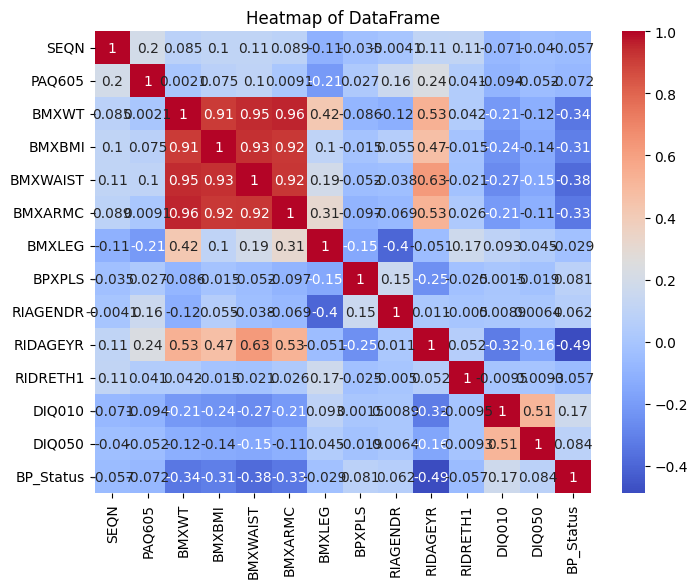

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(DF.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of DataFrame')
plt.show()

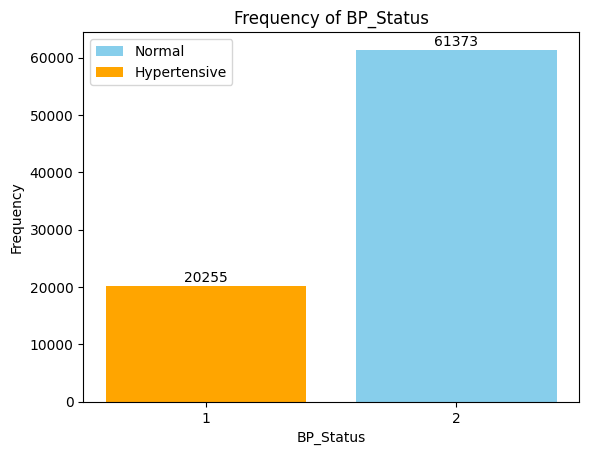

In [51]:
bars = plt.bar(DF['BP_Status'].value_counts().index, 
               DF['BP_Status'].value_counts().values, 
               color=['skyblue', 'orange'])

plt.legend(bars, ['Normal', 'Hypertensive'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, yval, ha='center', va='bottom')

plt.title('Frequency of BP_Status')
plt.xlabel('BP_Status')
plt.ylabel('Frequency')
plt.xticks([1, 2])

plt.show()


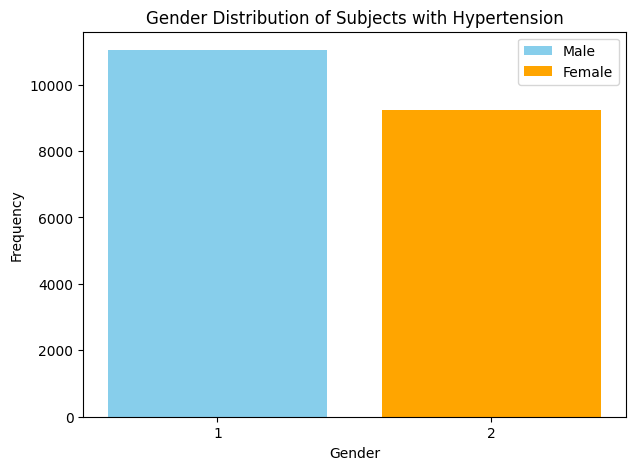

In [52]:
df_hypertension = DF[DF['BP_Status'] == 1]

gender_counts = df_hypertension['RIAGENDR'].value_counts().sort_index()
colors = ['skyblue', 'orange']
plt.figure(figsize=(7,5))
bars = plt.bar(gender_counts.index, gender_counts.values, color=colors)

plt.legend(bars, ['Male', 'Female'])

plt.title('Gender Distribution of Subjects with Hypertension')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks([1, 2])

plt.show()

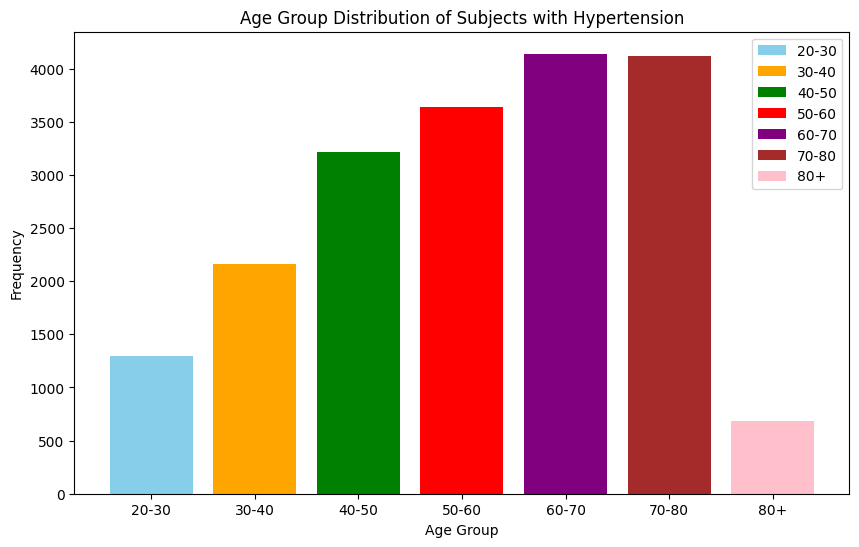

In [53]:
bins = [20, 30, 40, 50, 60, 70, 80, np.inf]
names = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']

DF['AgeGroup'] = pd.cut(DF['RIDAGEYR'], bins, labels=names)
df_hypertension = DF[DF['BP_Status'] == 1]

age_group_counts = df_hypertension['AgeGroup'].value_counts().sort_index()
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
plt.figure(figsize=(10,6))
bars = plt.bar(age_group_counts.index, age_group_counts.values, color=colors)

plt.legend(bars, names)

plt.title('Age Group Distribution of Subjects with Hypertension')
plt.xlabel('Age Group')
plt.ylabel('Frequency')

plt.show()

DF.drop(columns=["AgeGroup"], inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


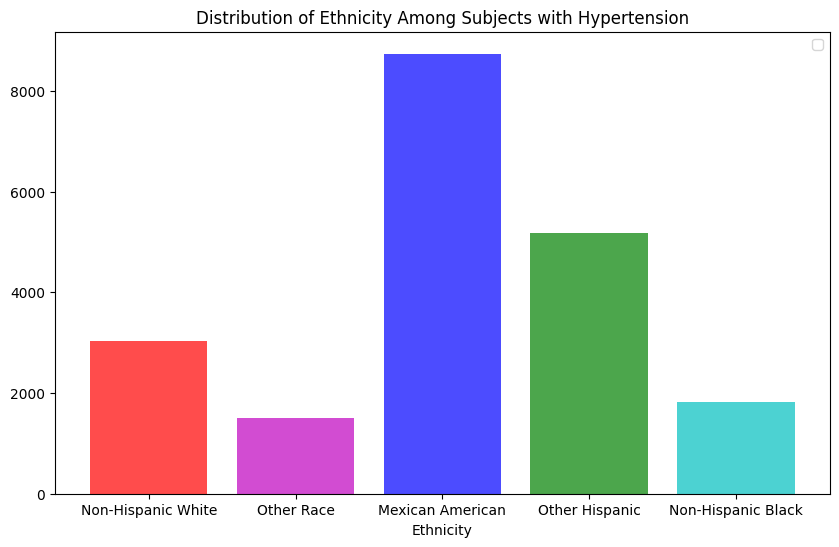

In [54]:
df_hypertension = DF[DF['BP_Status'] == 1]

ethnicity_counts = df_hypertension['RIDRETH1'].value_counts()
colors = ['b', 'g', 'r', 'c', 'm']

plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color=colors, alpha=0.7)
plt.xticks(ethnicity_counts.index, ['Mexican American', 'Other Hispanic', 'Non-Hispanic White', 'Non-Hispanic Black', 'Other Race'])
plt.title('Distribution of Ethnicity Among Subjects with Hypertension')
plt.xlabel('Ethnicity')
plt.legend()
plt.show()

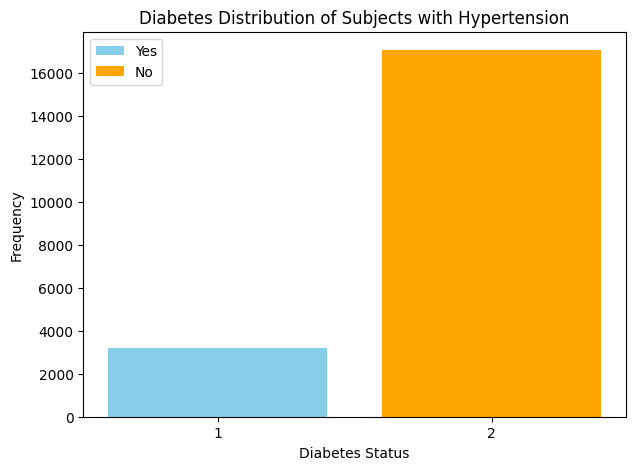

In [55]:
df_hypertension = DF[DF['BP_Status'] == 1]

diabetes_counts = df_hypertension['DIQ010'].value_counts().sort_index()
colors = ['skyblue', 'orange']
plt.figure(figsize=(7,5))
bars = plt.bar(diabetes_counts.index, diabetes_counts.values, color=colors)

plt.legend(bars, ['Yes', 'No'])

plt.title('Diabetes Distribution of Subjects with Hypertension')
plt.xlabel('Diabetes Status')
plt.ylabel('Frequency')
plt.xticks([1,2])

plt.show()


<Figure size 1000x600 with 0 Axes>

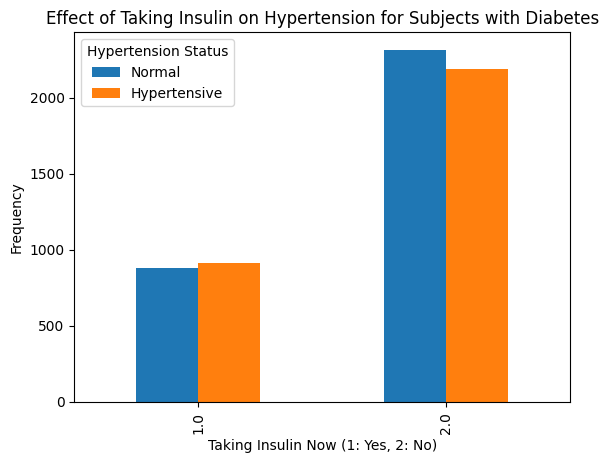

In [56]:

df_diabetes = DF[DF['DIQ010'] == 1]

plt.figure(figsize=(10,6))
df_diabetes.groupby('DIQ050')['BP_Status'].value_counts().unstack().plot(kind='bar', stacked=False)

plt.title('Effect of Taking Insulin on Hypertension for Subjects with Diabetes')
plt.xlabel('Taking Insulin Now (1: Yes, 2: No)')
plt.ylabel('Frequency')

plt.legend(title='Hypertension Status', labels=['Normal', 'Hypertensive'])

plt.show()


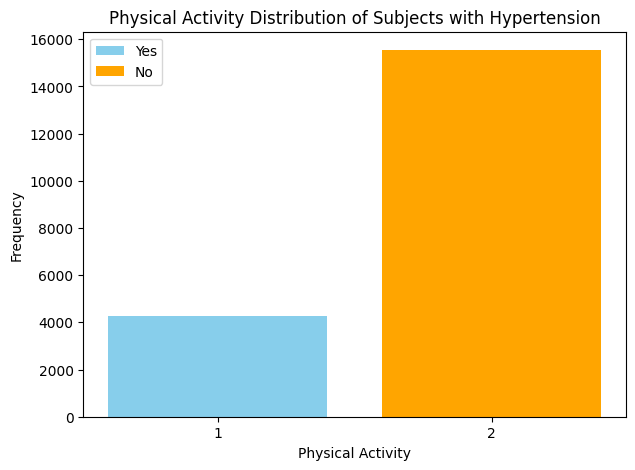

In [57]:
df_hypertension = DF[DF['BP_Status'] == 1]

gender_counts = df_hypertension['PAQ605'].value_counts().sort_index()
colors = ['skyblue', 'orange']
plt.figure(figsize=(7,5))
bars = plt.bar(gender_counts.index, gender_counts.values, color=colors)

plt.legend(bars, ['Yes', 'No'])

plt.title('Physical Activity Distribution of Subjects with Hypertension')
plt.xlabel('Physical Activity')
plt.ylabel('Frequency')
plt.xticks([1, 2])

plt.show()

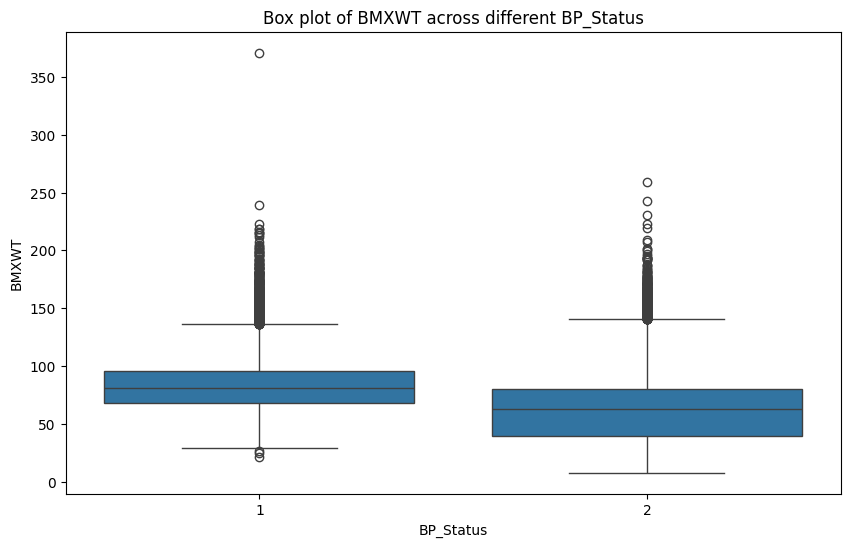

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='BP_Status', y='BMXWT', data=DF)
plt.title('Box plot of BMXWT across different BP_Status')
plt.show()


**BP_Status 1**: The median `BMXWT` (the line inside the box) is around 100. The interquartile range (the height of the box) is compact, indicating less variability in the data. There are several outliers (represented by circles) above the upper whisker, with `BMXWT` values extending up to approximately 250.

**BP_Status 2**: The median `BMXWT` is also around 100 but has more outliers compared to `BP_Status` 1. These outliers extend up to a higher value of approximately 300 on the y-axis.

This suggests that for both `BP_Status` categories, the median `BMXWT` is similar. However, `BP_Status` 2 has more extreme values of `BMXWT`.

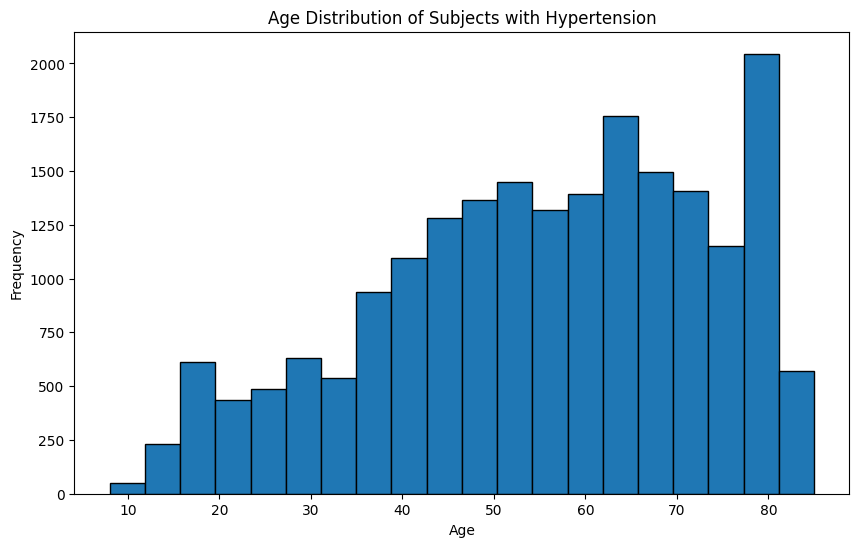

In [59]:
df_hypertension = DF[DF['BP_Status'] == 1]

plt.figure(figsize=(10,6))
plt.hist(df_hypertension['RIDAGEYR'], bins=20, edgecolor='black')

plt.title('Age Distribution of Subjects with Hypertension')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

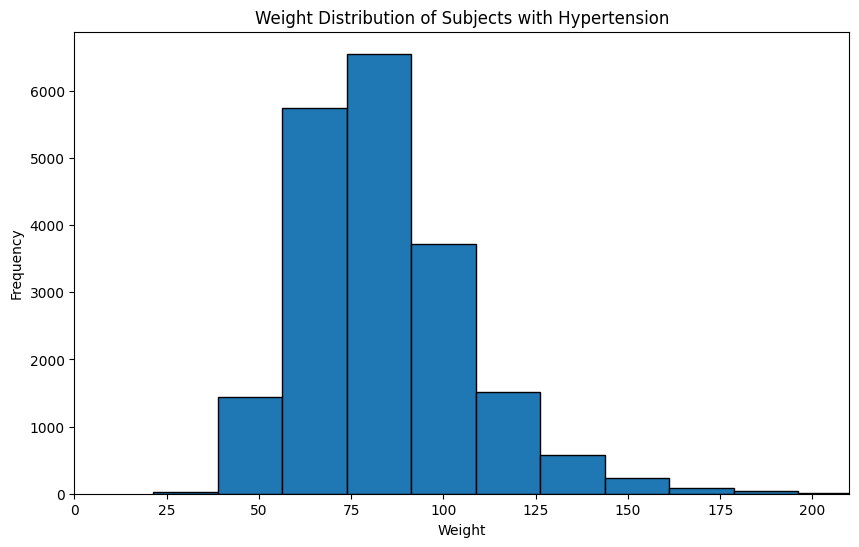

In [60]:
df_hypertension = DF[DF['BP_Status'] == 1]

plt.figure(figsize=(10,6))
plt.hist(df_hypertension['BMXWT'], bins=20, edgecolor='black')

plt.title('Weight Distribution of Subjects with Hypertension')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.xlim(0, 210)

plt.show()

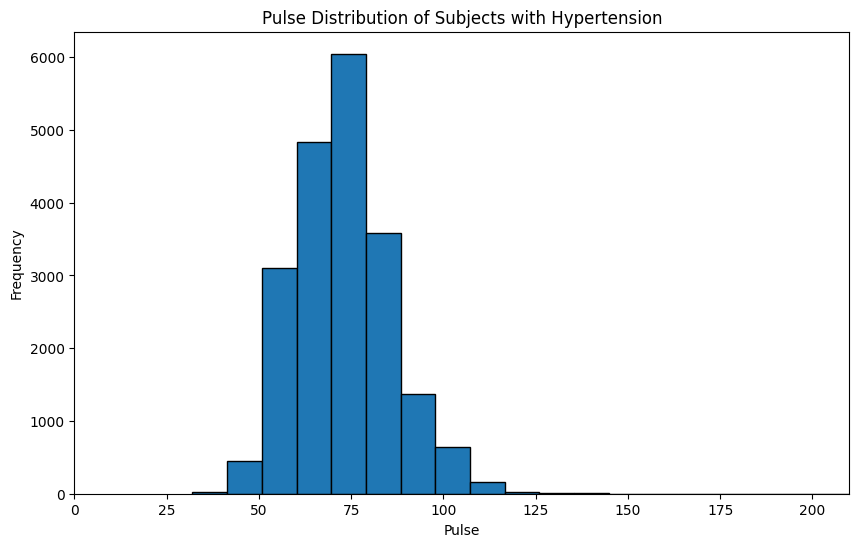

In [61]:
df_hypertension = DF[DF['BP_Status'] == 1]

plt.figure(figsize=(10,6))
plt.hist(df_hypertension['BPXPLS'], bins=20, edgecolor='black')

plt.title('Pulse Distribution of Subjects with Hypertension')
plt.xlabel('Pulse')
plt.ylabel('Frequency')
plt.xlim(0, 210)

plt.show()

<Figure size 1000x600 with 0 Axes>

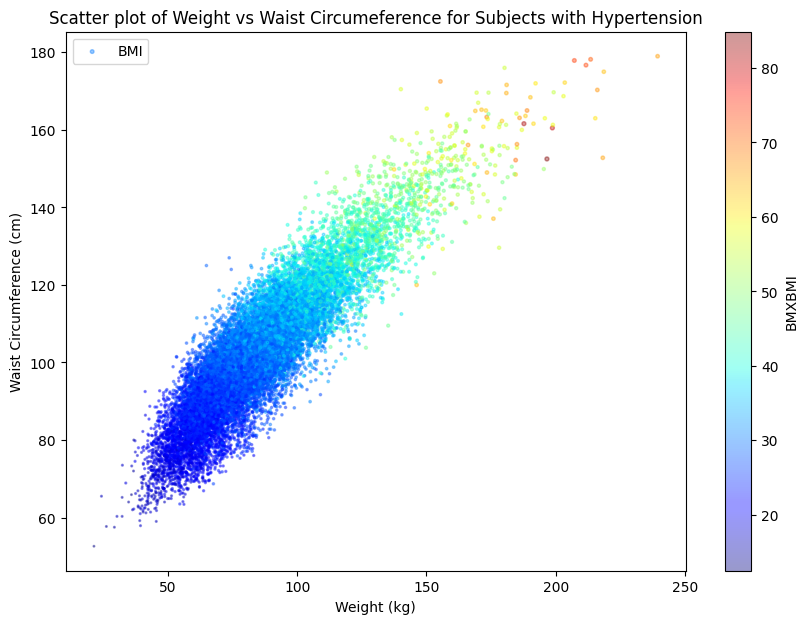

In [62]:
plt.figure(figsize=(10, 6))
size = df_hypertension["BMXBMI"]/10

df_hypertension.plot(kind="scatter", x="BMXWT", y="BMXWAIST", alpha=0.4,
                    s=size, label="BMI", figsize=(10,7),
                    c="BMXBMI", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

plt.title('Scatter plot of Weight vs Waist Circumeference for Subjects with Hypertension')
plt.xlabel('Weight (kg)')
plt.ylabel('Waist Circumference (cm)')
plt.show()

# PART 3

## 1. PREPROCESSING

In [63]:
DFML = DF.copy()

# Dropping the Gender and Ethnicity Column
DFML.drop(columns=["SEQN", "RIDRETH1", "RIAGENDR"], inplace=True)
DFML = DFML.fillna(DFML.median()) #replace null values with median column
DFML.isnull().sum()

PAQ605       0
BMXWT        0
BMXBMI       0
BMXWAIST     0
BMXARMC      0
BMXLEG       0
BPXPLS       0
RIDAGEYR     0
DIQ010       0
DIQ050       0
BP_Status    0
dtype: int64

In [64]:
DFML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81628 entries, 0 to 81627
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAQ605     81628 non-null  float64
 1   BMXWT      81628 non-null  float64
 2   BMXBMI     81628 non-null  float64
 3   BMXWAIST   81628 non-null  float64
 4   BMXARMC    81628 non-null  float64
 5   BMXLEG     81628 non-null  float64
 6   BPXPLS     81628 non-null  float64
 7   RIDAGEYR   81628 non-null  float64
 8   DIQ010     81628 non-null  float64
 9   DIQ050     81628 non-null  float64
 10  BP_Status  81628 non-null  int32  
dtypes: float64(10), int32(1)
memory usage: 6.5 MB


In [65]:
DFML.head()

,PAQ605,BMXWT,BMXBMI,BMXWAIST,BMXARMC,BMXLEG,BPXPLS,RIDAGEYR,DIQ010,DIQ050,BP_Status
0,1.0,91.7,30.22,100.8,37.2,39.8,52.0,39.0,2.0,2.0,1
1,1.0,84.0,29.98,88.7,37.1,41.5,56.0,23.0,2.0,2.0,2
2,2.0,51.7,24.62,86.1,29.3,32.0,88.0,84.0,2.0,2.0,2
3,1.0,58.0,22.26,74.0,27.2,38.7,90.0,51.0,2.0,2.0,2
4,2.0,139.1,39.23,129.0,43.5,47.0,70.0,16.0,2.0,2.0,1


## 2. SECONDARY MODELS (SVM, LR, KNN, NB, RFC, DTC)

### 2.1 SPLITTING DATA

In [66]:
X = DFML.drop(columns=['BP_Status'])
y = DFML['BP_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

scale_columns = ['BMXWT', 'BMXBMI', 'BMXWAIST', 'BMXARMC', 'BMXLEG', 'BPXPLS', 'RIDAGEYR']

preprocessor = make_column_transformer(
    (StandardScaler(), scale_columns),
    remainder='passthrough'  # Leave remaining columns untouched
)

# Fit on the training data
preprocessor.fit(X_train)

# Transform the data
X_train = preprocessor.transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

### 2.2 TRAINING MODELS

In [67]:
models = ['SVM', 'LR', 'KNN', 'NB', 'RFC', 'DTC']
accuracies = []
precisions = []
f1_scores = []

for model in models:
  selector = ModelSelector(model)
  selector.fit(X_train, y_train)
  selector.predict(X_test)
  selector.evaluate(y_test)

  accuracies.append(selector.accuracy)
  precisions.append(selector.precision)
  f1_scores.append(selector.f1_score)

In [68]:
models_df = pd.DataFrame({
    'Model': ['Support Vector Machine', 'Linear Regression',
              'K-Nearest Neigbor', 'Naive Bayes', 'Random Forest Classifier', 'Decision Tree Classifier'],
    'Accuracy': accuracies,
    'Precision': precisions,
    'F1-Score': f1_scores
    })

models_df.sort_values(by='Accuracy', ascending=False, inplace=True)
models_df.set_index('Model', inplace=True)

models_df

,Accuracy,Precision,F1-Score
Model,,,
Random Forest Classifier,0.789293,0.579832,0.567187
Support Vector Machine,0.786190,0.599953,0.494985
K-Nearest Neigbor,0.774960,0.553231,0.522402
Linear Regression,0.773898,0.559647,0.484211
Naive Bayes,0.754543,0.505401,0.554642
Decision Tree Classifier,0.736331,0.470804,0.477547


## 3. PRIMARY MODEL (MPC)

### 3.1 SPLITTING DATA

In [73]:
X = DFML.drop('BP_Status', axis=1)
y = DFML['BP_Status'] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


### 3.2 TRAINING MODEL

In [74]:
# Create instances for each split
train_dataset = BP_Dataset(X_train, y_train)
val_dataset = BP_Dataset(X_val, y_val)
test_dataset = BP_Dataset(X_test, y_test)

# Define the DataLoader for each dataset
batch_size = 32  # You can change this value if you want
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Define the model
input_size = len(X_train.columns)  # Assuming X_train is a DataFrame
model = MLPClassifier(input_size)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01  # You can change this value if you want
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 10

trainer = Trainer(model, criterion, optimizer, patience=5)
trainer.train(train_loader, val_loader, num_epochs=10)

Epoch [1/10], Loss: 0.5697, Validation Loss: 0.4177, Validation Accuracy: 76.81612152394953%
Epoch [2/10], Loss: 0.3759, Validation Loss: 0.4102, Validation Accuracy: 78.03503613867451%
Epoch [3/10], Loss: 0.3258, Validation Loss: 0.4101, Validation Accuracy: 77.88803136101923%
Epoch [4/10], Loss: 0.5166, Validation Loss: 0.4085, Validation Accuracy: 77.88803136101923%
Epoch [5/10], Loss: 0.3025, Validation Loss: 0.4038, Validation Accuracy: 78.29229449957124%
Epoch [6/10], Loss: 0.4467, Validation Loss: 0.4107, Validation Accuracy: 76.86512311650128%
Epoch [7/10], Loss: 0.3600, Validation Loss: 0.4032, Validation Accuracy: 78.12691412470905%
Epoch [8/10], Loss: 0.3899, Validation Loss: 0.4097, Validation Accuracy: 78.67818204091633%
Epoch [9/10], Loss: 0.3074, Validation Loss: 0.4056, Validation Accuracy: 78.30454489770918%
Epoch [10/10], Loss: 0.3782, Validation Loss: 0.4082, Validation Accuracy: 77.90640695822614%


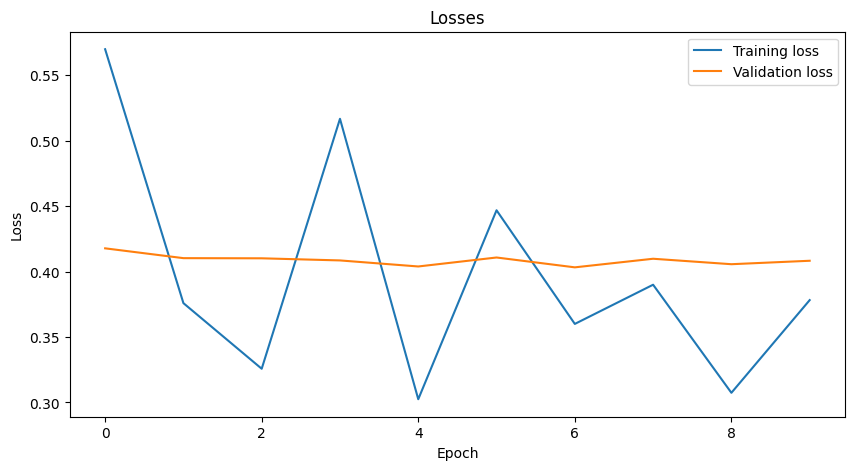

In [75]:
trainer.plot_losses()

## Summary

**Loss and Validation Loss**
The loss on the training set fluctuates, suggesting the model might be having difficulty generalizing the data. Ideally, we would want to see a steady decrease in loss over epochs. The validation loss is mostly stable, indicating the model might not be overfitting but could be struggling to learn effectively.

**Accuracy**
The validation accuracy increases over epochs, indicating the model is learning and improving its predictions on the validation set. However, the increase is not consistent, suggesting the model might be struggling to learn some patterns in the data.

**Overfitting or Underfitting**
If the training loss is much lower than the validation loss, it's a sign of overfitting. If the training loss is higher than the validation loss, it's a sign of underfitting.



In [72]:
%%shell
jupyter nbconvert --to html /content/analysis.ipynb

UsageError: Cell magic `%%shell` not found.
